In [119]:
from genericpath import exists
import os
import json
from matplotlib import pyplot as plt
from joblib import Parallel, delayed

from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
import numpy as np
import tables as tb
from twd import TWD

In [120]:

# Load PATH variable
with open("config.json", "r") as file:
    config = json.load(file)
DATASETS = config["paths"]["DATASETS"]
DATABASES = config["paths"]["DATABASES"]

In [121]:
# -1 para usar todas as threads disponíveos
NTHREADS = -1

#paths
datasets_path = DATASETS
name = "lbp|radius=5|n_points=40|n_samples=10192.hdf5"
dt_name = "lbp_dt|res=20|radius=5|n_points=40|n_samples=10192.hdf5"

# resolução para a construção das decision tables. Sera usado como passo no for de -100, 100
resolution = 1

In [122]:
def calculate_dt_rows(delta_rows, i, resolution):
    delta_row = delta_rows[i, :]
    dt_row = []
    #print(delta_row)
    for delta in delta_row:
        # começa na esquerda da distribuição normal e vai até a direita, em passos
        # de tamanho da resolução indicada
        lower_bnd = -100
        flag = True
        while(lower_bnd != 100 and flag):
            if delta <= lower_bnd:
                dt_row.append(lower_bnd)
                flag = False
            lower_bnd += resolution
        if flag:
            dt_row.append(lower_bnd)
    
    return dt_row


In [123]:
def build_decision_table():

    decision_table_name = os.path.join(datasets_path, dt_name)
    original_dataset_name = os.path.join(datasets_path, name)

    with tb.open_file(original_dataset_name, "r") as hdf5:
        table = hdf5.get_node("/dataset")
        num_cols = table.row["descriptor"].size
        num_rows = table.nrows
        labels = table.col("label")
        descriptors = table.col("descriptor")
        print(descriptors)
    
    # criação do arquivo hdf5
    with tb.open_file(decision_table_name, "w") as hdf5_dt:
        filters = tb.Filters(
            complevel=9, complib="blosc", shuffle=True, bitshuffle=True
        )

        class Dataset(tb.IsDescription):
            label = tb.StringCol(itemsize=16)
            descriptor = tb.Int16Col(shape=(num_cols,))

        dt_table = hdf5_dt.create_table(
            "/", "dataset", Dataset, filters=filters, expectedrows=num_rows
        )

    # calcula deltas por coluna, e então transpoem colunas para ter mariz no shape correto
    delta_cols = []
    for i in range(num_cols):
        mean = np.mean(descriptors[:,i])
        std = np.std(descriptors[:,i])
        delta_col = ((descriptors[:,i]-mean)/std)*100
        delta_cols.append(delta_col)
    delta_rows = np.transpose(delta_cols)
    print(delta_rows)

    # calcula as linhas das tabela de decisão baseado nas médias das colunas e na resolução
    # do operador (tamanho do intervalo)
    dt_rows = Parallel(n_jobs=NTHREADS)(
        delayed(calculate_dt_rows)(delta_rows, i, resolution)
        for i in range(num_rows)
    )
    
    print(dt_rows)

    # plot histogram
    data = np.asarray(dt_rows).ravel()
    plt.hist(data,bins=200, range=(-100,100), rwidth = 0.7)
    plt.plot()

    with tb.open_file(decision_table_name, "r+") as hdf5_dt:
        dt_table = hdf5_dt.get_node("/dataset")
        dt_row = dt_table.row
        for i in range(num_rows):
            dt_row["label"] = labels[i]
            dt_row["descriptor"] = dt_rows[i]
            dt_row.append()
            dt_table.flush()

[[ 1592.   902.   821. ...   510.  1888. 35502.]
 [ 2456.  1076.  1051. ...   591.  2761. 37866.]
 [ 2183.   804.   898. ...   543.  2084. 33510.]
 ...
 [ 1113.   835.   734. ...   354.  2737. 25811.]
 [ 1414.   788.   789. ...   301.  2703. 25372.]
 [ 1468.   863.   667. ...   352. 11169. 21836.]]
[[-35.34795404 -34.1137692  -36.73518714 ... -38.27310216 -40.70946215
  -38.0701951 ]
 [-33.83072362 -33.72589305 -34.78298055 ... -38.00188071 -40.66974659
  -37.8718013 ]
 [-34.31012629 -34.33222818 -36.08162233 ... -38.16260453 -40.70054548
  -38.23736956]
 ...
 [-36.18910378 -34.26312381 -37.4736305  ... -38.79545458 -40.67083842
  -38.88349216]
 [-35.66053161 -34.36789496 -37.00679849 ... -38.97292047 -40.67238519
  -38.92033433]
 [-35.5657047  -34.20070696 -38.04231677 ... -38.80215141 -40.28723978
  -39.21708579]]
[[-35, -34, -36, -39, -42, -42, -42, -41, -42, -41, -43, -39, -37, -39, -37, -41, -38, -40, -36, -31, -35, -34, -35, -39, -38, -39, -37, -37, -36, -38, -37, -38, -39, -39, 

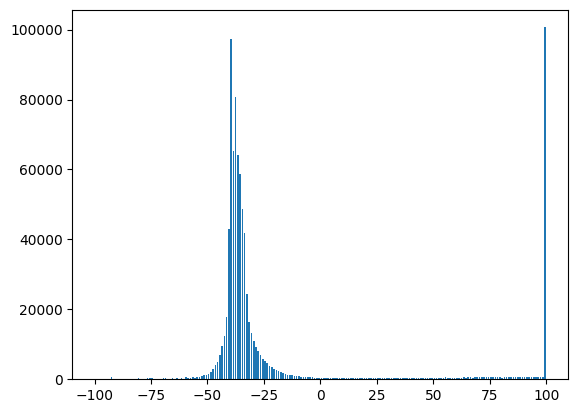

In [124]:
build_decision_table()
